### Time series analysis on Flight data

In this notebook I am loading the data from postgres table 'flight_info' rather than directly reading from a csv file.

I have practiced several important concept of time series data analysis here, namely:
    1. Different plotting techniques useful for time series data.
    2. Used 'Rolling Mean' and 'Rolling Standard Deviation' for analyzing non-stationarity in the data.
    3. Applied 'log', 'moving average' and 'exponential weighted mean' methods to bring stationarity in the data.
    4. Applied 'Difference' and 'Decomposition' approach on top of above methods to work more on stationarity.
    5. Create an ARIMA model on top of difference method outcome to get best outcomes.

In [ ]:
%matplotlib inline
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime

In [97]:
conn = pg.connect(host="localhost", database="flights", user="postgres", password="postgres", port="5432");

In [208]:
df = pd.read_sql('select * from flight_info', conn)

In [209]:
df.shape

(336776, 19)

In [210]:
df.dtypes

year               int64
month              int64
day                int64
dep_time          object
sched_dep_time    object
dep_delay          int64
arr_time          object
sched_arr_time    object
arr_delay          int64
carrier           object
flight             int64
tailnum           object
origin            object
dest              object
air_time          object
distance           int64
hour               int64
minute             int64
time_hour         object
dtype: object

In [211]:
df.head(1)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517,515,2,830,819,11,UA,1545,N14228,EWR,IAH,227,1400,5,15,2013-01-01


In [212]:
df['time_hour'] = pd.to_datetime(df['time_hour'], format='%Y-%m-%d')
df = df.set_index('time_hour')

In [213]:
df['flight_date'] = df.index.date
df['day_of_week'] = df.index.dayofweek

In [214]:
flights_by_date = df[['flight_date', 'flight']].groupby(['flight_date']).agg(np.size)

In [215]:
flights_by_dow = df[['day_of_week', 'flight']].groupby(['day_of_week']).agg(np.size)

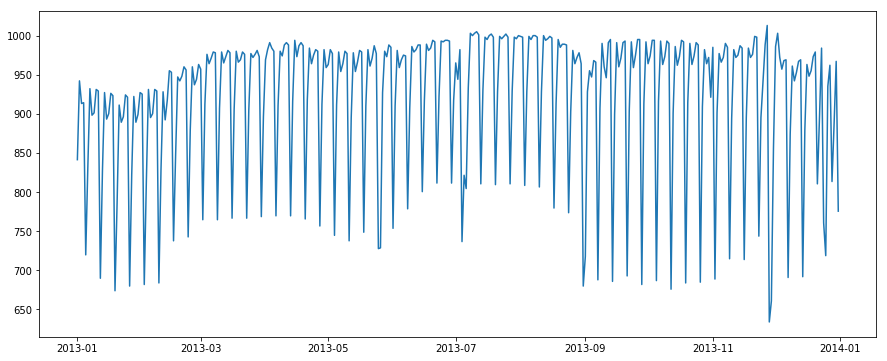

In [216]:
plt.plot(flights_by_date)

{'boxes': [<matplotlib.lines.Line2D at 0x7f3c37314128>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3c37314b38>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3c371747f0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3c371743c8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3c37314278>,
  <matplotlib.lines.Line2D at 0x7f3c391b9860>]}

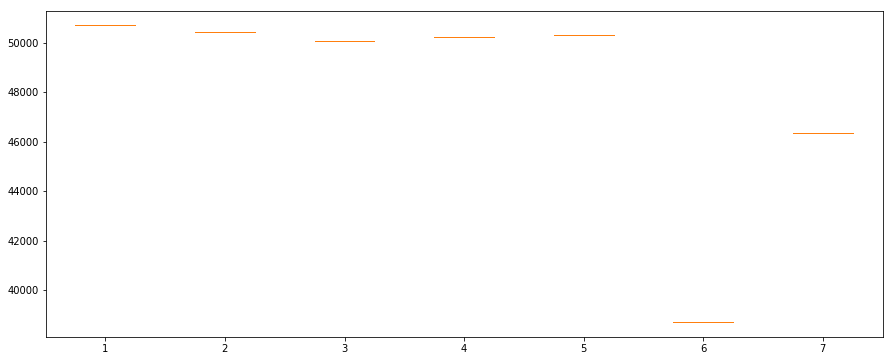

In [217]:
plt.boxplot(flights_by_dow)

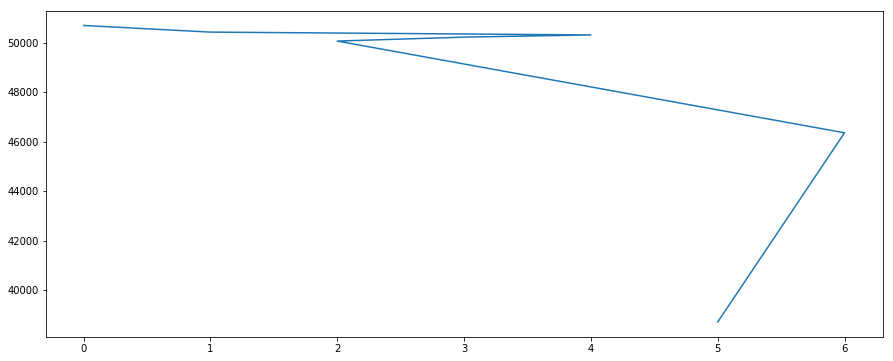

In [218]:
plt.plot(df.day_of_week.value_counts())

In [243]:
df['#flights'] = 1

In [248]:
ts = df[['#flights']]

In [249]:
ts1 = ts.resample('D').sum()

In [250]:
ts1.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='time_hour', length=365, freq='D')

In [252]:
ts2 = ts1['#flights']

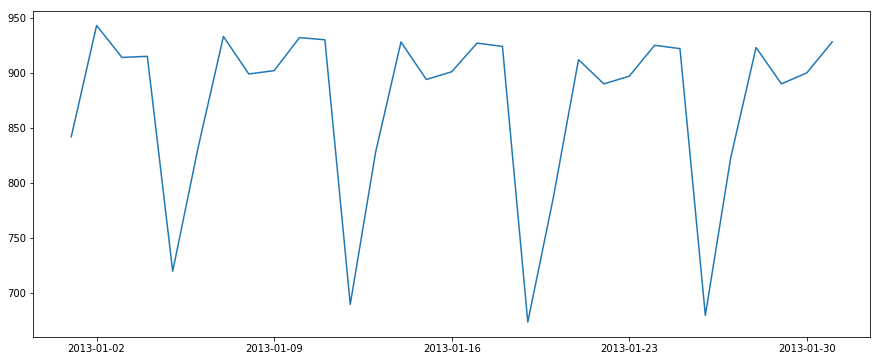

In [263]:
plt.plot(ts2['2013-01'])

In [265]:
from statsmodels.tsa.stattools import adfuller

In [300]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

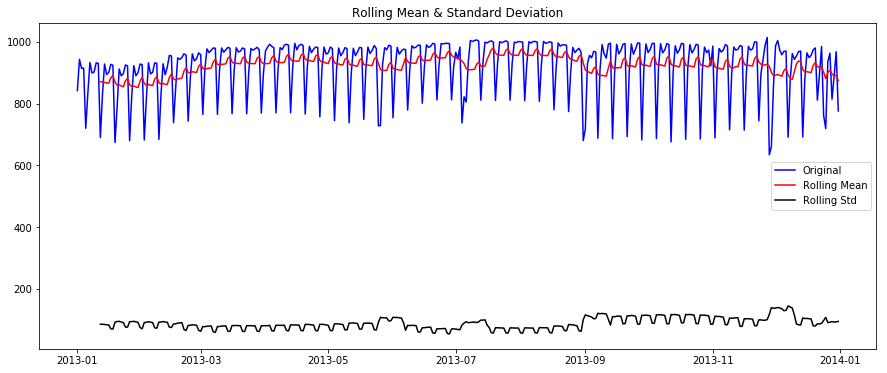

Results of Dickey-Fuller Test:
Test Statistic                  -2.299635
p-value                          0.172086
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (5%)             -2.869833
Critical Value (1%)             -3.449173
Critical Value (10%)            -2.571188
dtype: float64


In [275]:
test_stationarity(ts2)

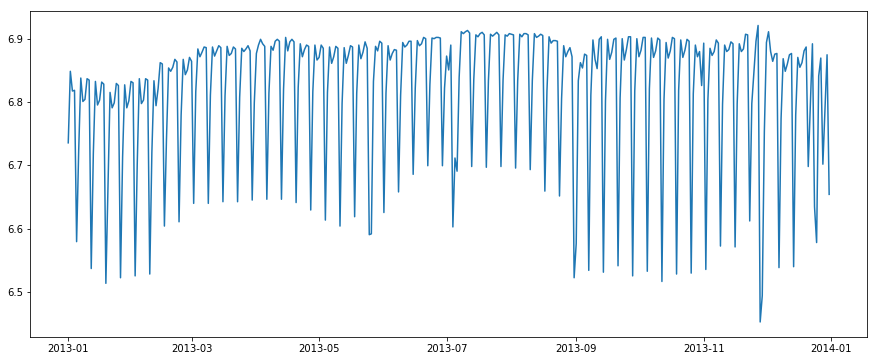

In [276]:
ts_log = np.log(ts2)
plt.plot(ts_log)

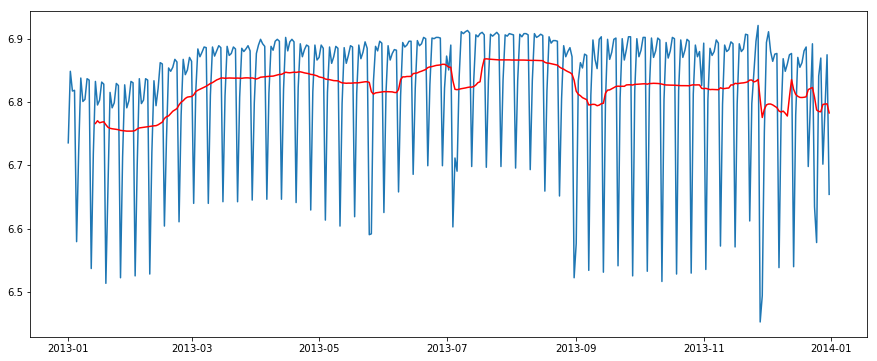

In [293]:
moving_avg = ts_log.rolling(14).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [296]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(14)

time_hour
2013-01-01         NaN
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-07         NaN
2013-01-08         NaN
2013-01-09         NaN
2013-01-10         NaN
2013-01-11         NaN
2013-01-12         NaN
2013-01-13         NaN
2013-01-14    0.066586
Freq: D, Name: #flights, dtype: float64

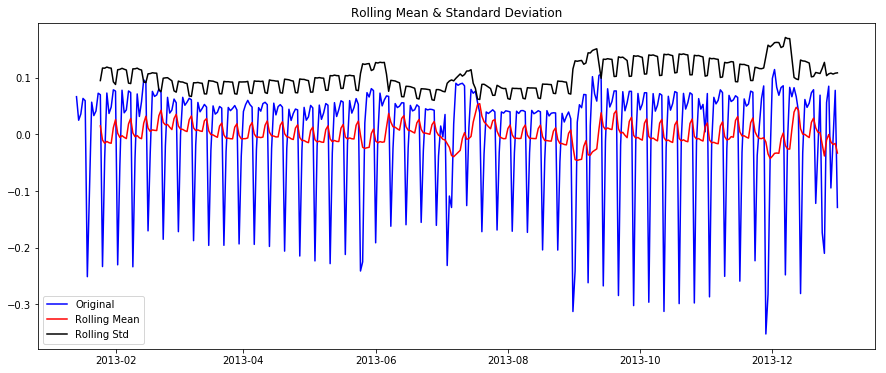

Results of Dickey-Fuller Test:
Test Statistic                  -5.374673
p-value                          0.000004
#Lags Used                      14.000000
Number of Observations Used    337.000000
Critical Value (5%)             -2.870155
Critical Value (1%)             -3.449904
Critical Value (10%)            -2.571360
dtype: float64


In [301]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

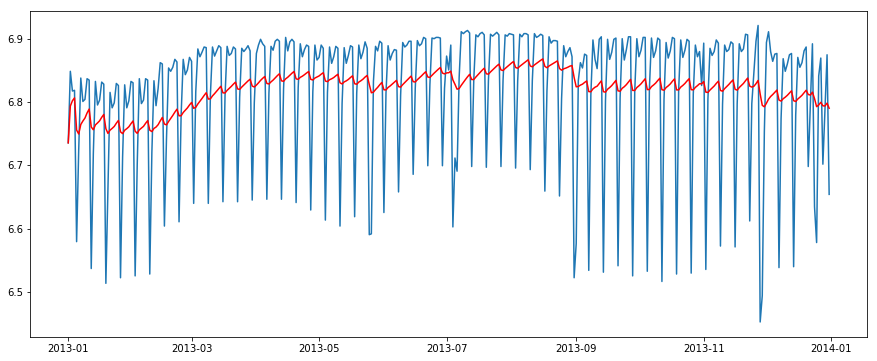

In [326]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

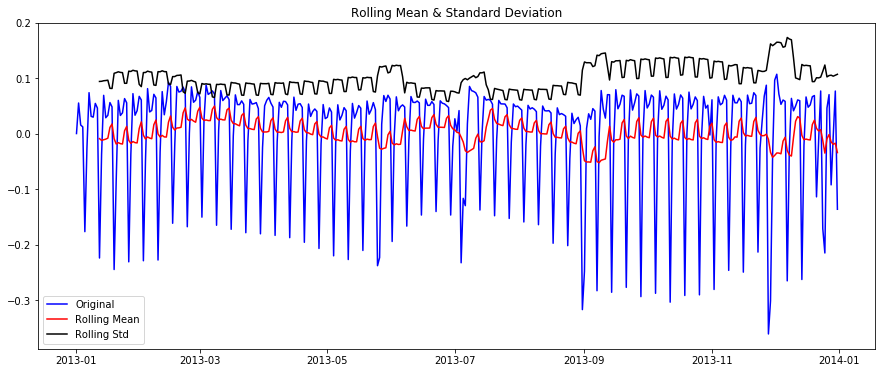

Results of Dickey-Fuller Test:
Test Statistic                  -3.715203
p-value                          0.003904
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (5%)             -2.869833
Critical Value (1%)             -3.449173
Critical Value (10%)            -2.571188
dtype: float64


In [327]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### Difference Approach

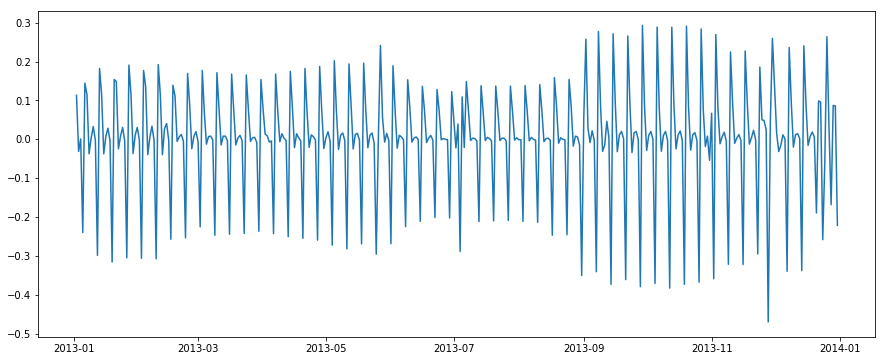

In [328]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

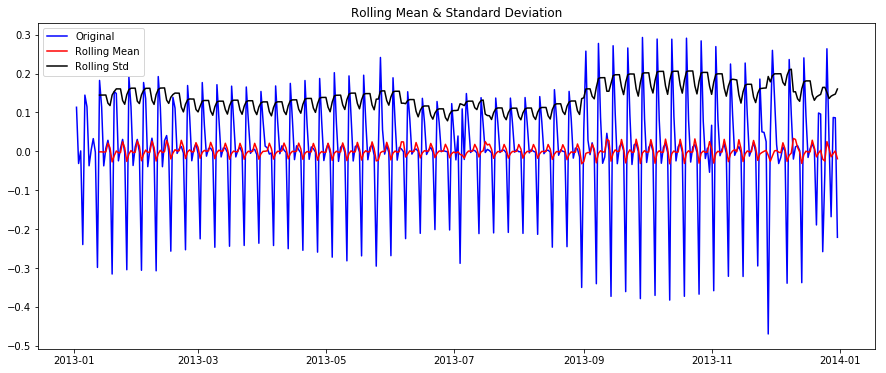

Results of Dickey-Fuller Test:
Test Statistic                -8.017330e+00
p-value                        2.121570e-12
#Lags Used                     1.400000e+01
Number of Observations Used    3.490000e+02
Critical Value (5%)           -2.869857e+00
Critical Value (1%)           -3.449227e+00
Critical Value (10%)          -2.571201e+00
dtype: float64


In [329]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decompose Approach

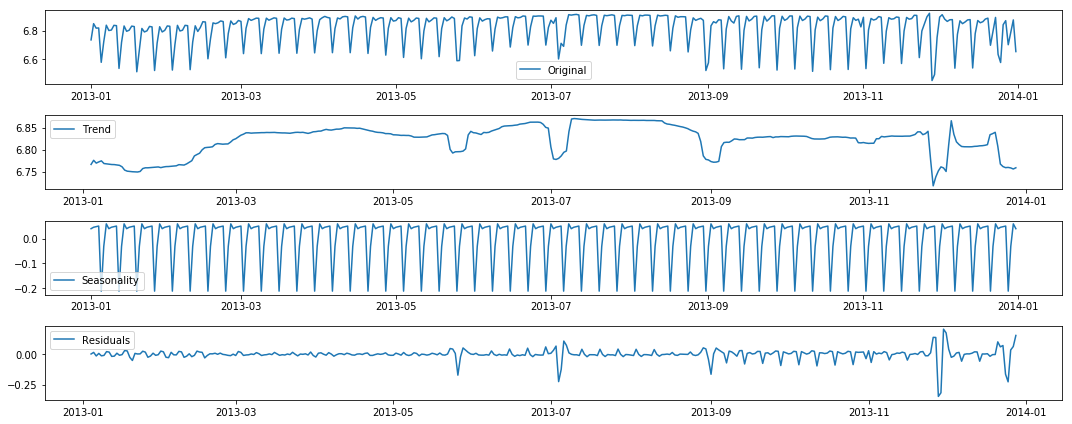

In [330]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

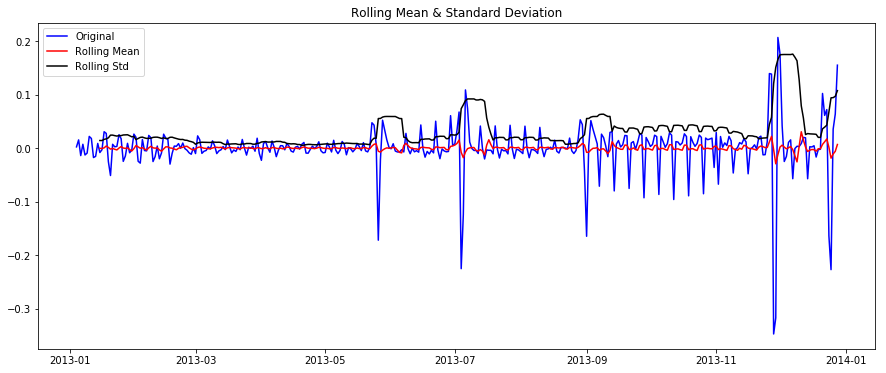

Results of Dickey-Fuller Test:
Test Statistic                -9.487274e+00
p-value                        3.733533e-16
#Lags Used                     1.700000e+01
Number of Observations Used    3.410000e+02
Critical Value (5%)           -2.870053e+00
Critical Value (1%)           -3.449673e+00
Critical Value (10%)          -2.571306e+00
dtype: float64


In [331]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# ARIMA

### Using Difference approach with ARIMA

In [332]:
from statsmodels.tsa.stattools import acf, pacf

In [333]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

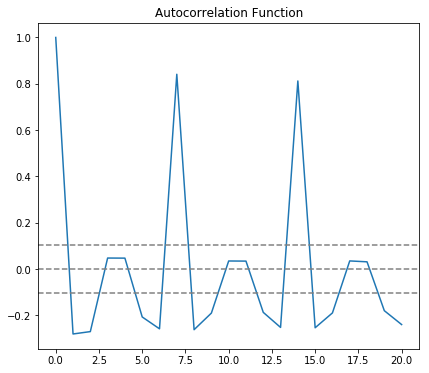

In [334]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

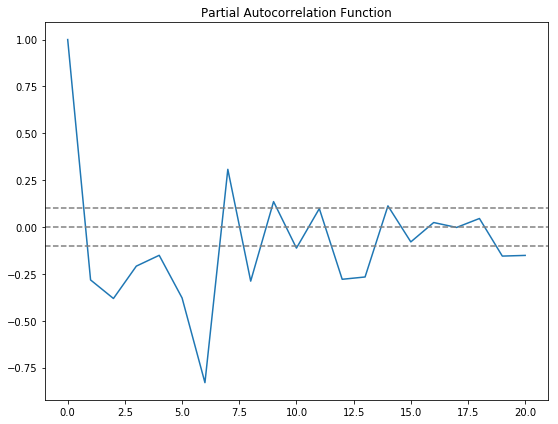

In [335]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [336]:
from statsmodels.tsa.arima_model import ARIMA

## AR Model

Text(0.5,1,'RSS: 5.5642')

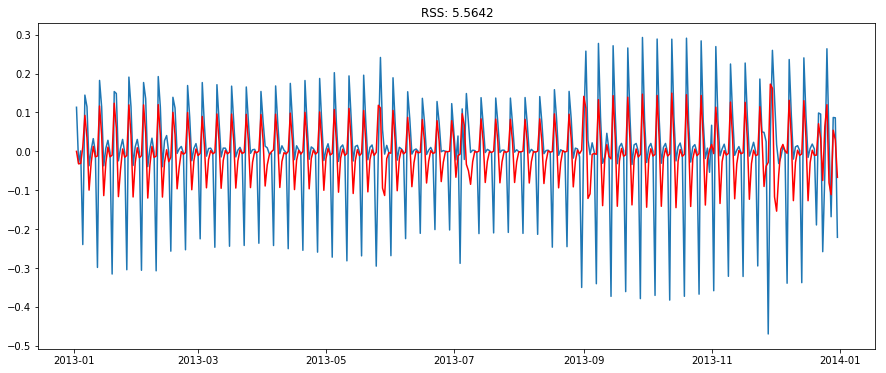

In [348]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

Text(0.5,1,'RSS: 4.0562')

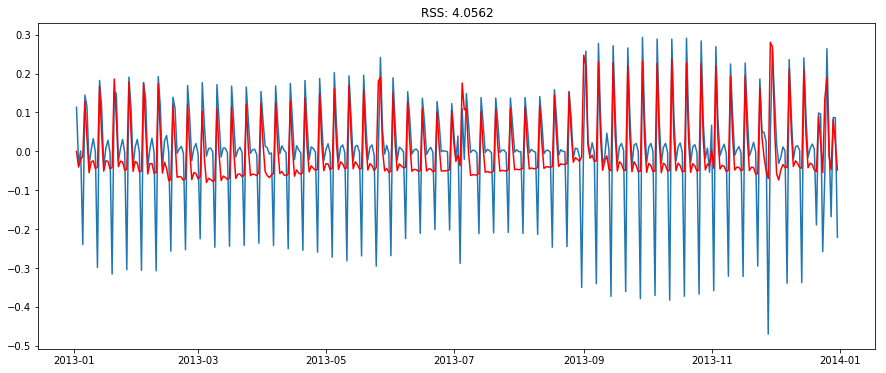

In [351]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## Combined Model

Text(0.5,1,'RSS: 3.4815')

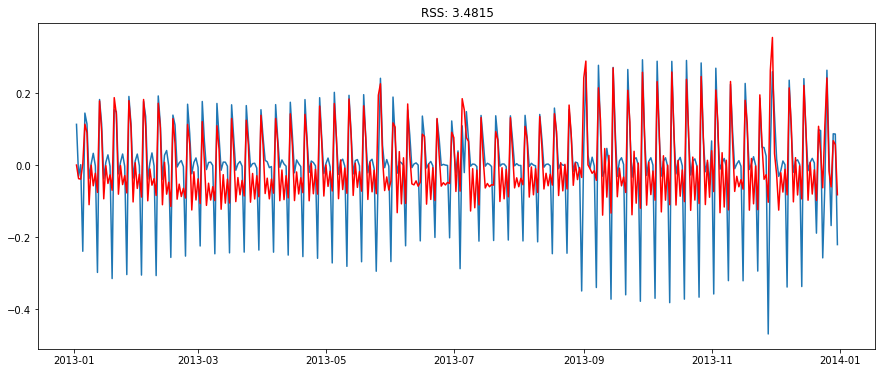

In [352]:
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [354]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

time_hour
2013-01-02    0.000070
2013-01-03   -0.037721
2013-01-04   -0.039025
2013-01-05    0.003188
2013-01-06    0.113726
Freq: D, dtype: float64


In [356]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

time_hour
2013-01-02    0.000070
2013-01-03   -0.037651
2013-01-04   -0.076676
2013-01-05   -0.073488
2013-01-06    0.040237
Freq: D, dtype: float64


In [358]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

time_hour
2013-01-01    6.735780
2013-01-02    6.735850
2013-01-03    6.698129
2013-01-04    6.659104
2013-01-05    6.662292
Freq: D, dtype: float64

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts2)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts2)**2)/len(ts2)))